In [43]:
import numpy as np
import matplotlib.pyplot as plt
import spaudiopy as spa
from pathlib import Path
import glob

Copy of the Sector_AnalysisSynthesis Notbook with Input of the 'Applied Acoustics/ORG/HOA/'-SRIR

In [44]:
# Publication stuff
default_figsize = (3.39, 3.0)
plt.rcParams['figure.figsize'] = default_figsize
font = {'family' : 'serif',
        'size'   : 9}
plt.rc('font', **font)
plt.rcParams['axes.titlesize'] = 9

In [45]:
N_sph = 3
shtype = 'real'

ENREC = True  # amplitude or energy reconstruction
pattern = "maxRE"

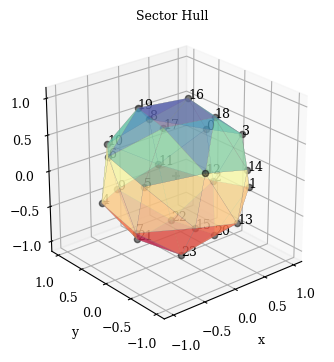

In [46]:
# steering of sectors
N_sph_sec = N_sph
sec_vecs = spa.grids.load_t_design(2*N_sph_sec if ENREC else N_sph_sec+1)  # N+1 or 2N
sec_azi, sec_zen, _ = spa.utils.cart2sph(*sec_vecs.T)
# number of sectors
J_sec = len(sec_vecs)
spa.plot.hull(spa.decoder.get_hull(*sec_vecs.T), title="Sector Hull")
plt.gcf().set_size_inches(3.3, 3.5)
#plt.savefig('figs/hull.pdf')

In [47]:
if pattern.lower() == "cardioid":
    c_n = spa.sph.cardioid_modal_weights(N_sph_sec)
elif pattern.lower() == "hypercardioid":
    c_n = spa.sph.hypercardioid_modal_weights(N_sph_sec)
elif pattern.lower() == "maxre":
    c_n = spa.sph.maxre_modal_weights(N_sph_sec, True)  # works with amplitude compensation and without!
else:
    assert()
A_sec = spa.sph.repeat_per_order(c_n) * \
            spa.sph.sh_matrix(N_sph_sec, sec_azi, sec_zen, shtype)

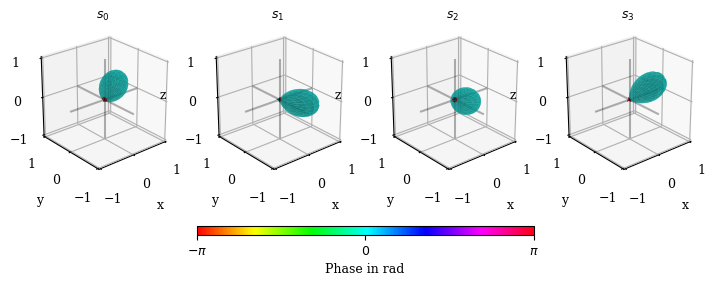

In [48]:
spa.plot.sh_coeffs_subplot([A_sec[0, :], A_sec[1, :],
                             A_sec[2, :], A_sec[3, :]],
                            titles=["$s_0$", "$s_1$", "$s_2$", "$s_3$"])
plt.gcf().set_size_inches(7, 3.5)

In [49]:
beta_a = np.sqrt(4*np.pi)/ (A_sec[0, 0] * J_sec)
beta_e = 1/ (A_sec[0, :].conj()@A_sec[0, :]/np.sqrt(4*np.pi) * J_sec/np.sqrt(4*np.pi))

In [50]:
# INPUT - changed - 
# load signal 
sig_len = 1  # in Samples
N_sph_in = N_sph

file_path = '/Users/viautopia/Nextcloud/Applied Acoustics/A10p/HOA/' 

in_path = glob.glob(file_path + '*.wav')

in_file = spa.io.load_audio(in_path)
in_sig = in_file.get_signals()

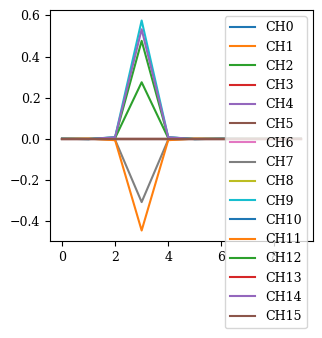

[0.0040642  0.01226056 0.47618055 0.02112234 0.0033052  0.01636636
 0.00416541 0.0462451  0.00256908 0.57504272 0.02055407 0.04746723
 0.27492297 0.00692308 0.53238606 0.00190115]
128


In [51]:
# - Additional content - 
# Plot of single Channels from the SRIR, code taken from Flo
for idx, signal in enumerate(in_sig):
    plt.plot(signal[125:135], label=f"CH{idx}")

plt.legend()
plt.show()

# Extracting the sample with highest value of the SRIR
max_sample = np.max(in_sig, axis= 1)
idx_max_sample = np.argmax(in_sig, axis = 1)
values, counts = np.unique(idx_max_sample, return_counts = True)

ind_max_sample = values[counts.argmax()]

print(max_sample)
print(ind_max_sample)

in_nm = in_sig[:,ind_max_sample:ind_max_sample+1].transpose() # Maximum Value of Channel 2 used, only for testing purpose
#print(in_sig)
#print(in_nm)

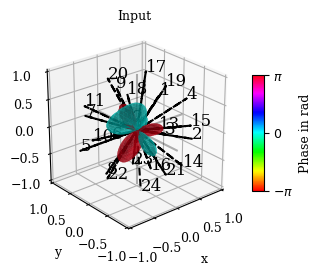

In [52]:
# following code unchanged from Sector_AnalysisSyntehsis Example-Notebook
fig = plt.figure()
spa.plot.sh_coeffs(in_nm, title="Input", fig=fig)
ax = fig.gca()
ax.plot(np.insert(sec_vecs[:, 0], np.arange(J_sec), np.zeros(J_sec)),
           np.insert(sec_vecs[:, 1], np.arange(J_sec), np.zeros(J_sec)), 
           np.insert(sec_vecs[:, 2], np.arange(J_sec), np.zeros(J_sec)),
           color='black', linestyle='dashed')
for s, co in enumerate(sec_vecs):
    ax.text(co[0], co[1], co[2], s+1, zorder=1, fontsize=12)
plt.savefig('input_sec_nm.pdf')

In [53]:
# Apply sectors
delta_numSH = (N_sph_in+1)**2 - (N_sph_sec+1)**2
pw_secs_out = np.c_[A_sec, np.zeros([J_sec, delta_numSH])] @ in_nm.T
pw_secs_out = np.real_if_close(pw_secs_out)

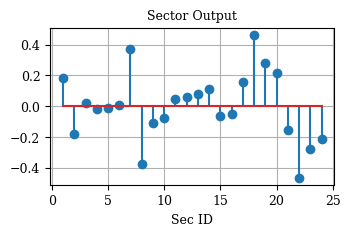

In [54]:
fig, ax = plt.subplots(figsize=(default_figsize[0], 3/4*default_figsize[1]), constrained_layout=True)
plt.stem(np.arange(J_sec)+1, pw_secs_out)
plt.xlabel("Sec ID")
plt.grid()
plt.title("Sector Output")
plt.savefig('sector_output.pdf')